### 1) Cross-correlation and Derivative Filter

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as stats

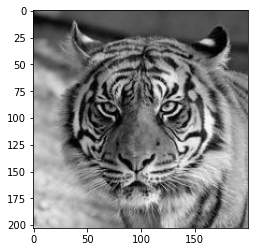

In [2]:
image = cv2.imread('tigerBW.jpg', 0)
plt.imshow(image, cmap='gray')
plt.show()

#### Cross-correlation Function

In [3]:
def cross_correlation(f, I):
    im_corr = np.zeros(shape=I.shape)
    
    if len(f.shape) == 1:
        f = f.reshape(1, len(f))
        hori_padding = f.shape[1] // 2
        vert_padding = 0
    else: 
        if f.shape[1] > 1:
            hori_padding = f.shape[1] // 2
        else:
            hori_padding = 0
        vert_padding = f.shape[0] // 2
    
    padded_image = np.zeros(shape=(I.shape[0] + 2*vert_padding,
                                   I.shape[1] + 2*hori_padding))
    
    padded_image[vert_padding:padded_image.shape[0]-vert_padding,
                 hori_padding:padded_image.shape[1]-hori_padding]=I

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            section = padded_image[i:i+f.shape[0], j:j+f.shape[1]]
            im_corr[i,j] = np.sum(section*f)
    
    return im_corr

#### Gaussian Filter Creation

In [4]:
def get_gaussian_filter(window_size):
    mu = 0
    sigma = 2

    x = np.linspace(-3*sigma, 3*sigma, window_size)
    gaussian = stats.norm.pdf(x, mu, sigma)

    gaussian = gaussian / np.sum(gaussian) # normalize
    
    return gaussian

#### Gaussian Denoising

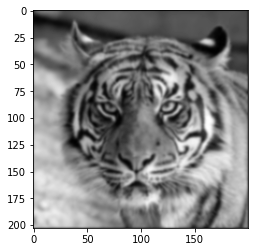

[0.00443305 0.05400558 0.24203623 0.39905028 0.24203623 0.05400558
 0.00443305]


In [5]:
gaussian_window = 7
gaussian = get_gaussian_filter(gaussian_window)
gauss_vert = gaussian[:,None]
gauss_hori = gaussian[None,:]

# Gaussian Denoising
blurred_image = cross_correlation(gauss_hori, image)
blurred_image = cross_correlation(gauss_vert, blurred_image)

plt.imshow(blurred_image, cmap='gray')
plt.show()

cv2.imwrite('blurred.jpg', blurred_image)

print(gaussian)

#### Derivative Filters

In [6]:
# Derivative Filters
fx = np.array([-1,0,1])
fy = fx[:,None]

#### Horizontal Derivative Image $G_x$

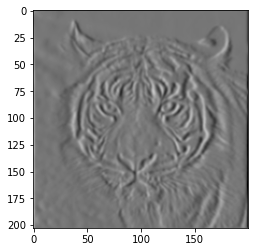

True

In [7]:
Gx = cross_correlation(fx, blurred_image)

plt.imshow(Gx, cmap='gray')
plt.show()

cv2.imwrite('Gx.jpg', Gx)

#### Horizontal Derivative Image $G_y$

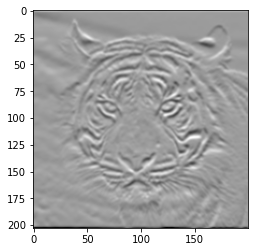

True

In [8]:
Gy = cross_correlation(fy, blurred_image)

plt.imshow(Gy, cmap='gray')
plt.show()

cv2.imwrite('Gy.jpg', Gy)

#### Gradient Magnitude $\sqrt{{G_x}^2 + {G_y}^2}$

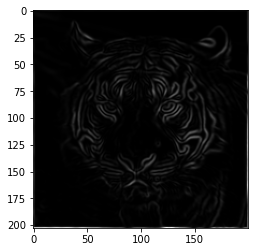

True

In [9]:
magnitude = (Gx**2 + Gy**2)

magnitude = 255 * (magnitude / np.max(magnitude)) # normalize

plt.imshow(magnitude, cmap='gray')
plt.show()

cv2.imwrite('magnitude.jpg', magnitude)

#### Gradient Direction Image

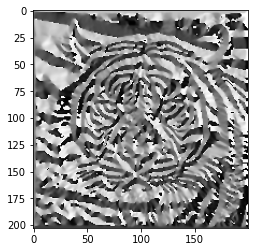

True

In [10]:
G_dir = np.zeros(shape=image.shape)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        G_dir[i,j] = np.arctan2(Gy[i,j], Gx[i,j])
        
plt.imshow(G_dir, cmap='gray')
plt.show()

cv2.imwrite('direction.jpg', G_dir)

#### IMPORTANT NOTES!!!

In [11]:
print(180 * G_dir / np.pi)

[[  39.95083666   68.12161307   77.94455104 ...   93.23821289
   103.6312894   135.11395376]
 [   2.6548324     7.93733145   15.14685635 ...  103.61522947
   136.07226667  166.90228264]
 [ -13.01188565  -34.19715682  -50.09024133 ...  142.37515398
   169.80537115  177.51282432]
 ...
 [   3.53924866   13.64272999   36.44700709 ...    9.57056461
  -177.68376691 -179.12308319]
 [  -9.03054764  -36.75015317  -79.15972425 ...  -72.62637723
  -131.68534879 -167.15825792]
 [ -44.19557348  -77.59513239  -88.51285084 ...  -87.27875792
  -101.41307659 -134.50242801]]


In [12]:
print(np.mod(G_dir, np.pi) / (np.pi / 4))

[[0.88779637 1.51381362 1.73210113 ... 2.07196029 2.30291754 3.00253231]
 [0.05899628 0.17638514 0.33659681 ... 2.30256065 3.02382815 3.70893961]
 [3.71084699 3.24006318 2.88688353 ... 3.16389231 3.77345269 3.94472943]
 ...
 [0.07864997 0.30317178 0.80993349 ... 0.21267921 0.05147185 0.01948704]
 [3.79932116 3.18332993 2.24089502 ... 2.38608051 1.07365892 0.28537205]
 [3.01787614 2.27566372 2.03304776 ... 2.06047205 1.74637608 1.01105716]]


Notes: from the result, the mapping provided is wrong. The 0 and 2 are inverted and also the 1 and 3 directions. Given that the y-axis points downward and not upward, the table values are inverted. More in report...

#### Threshold

In [13]:
def manual_threshold(im_in, threshold):
    res_image = np.zeros(shape=im_in.shape)
    
    for i in range(im_in.shape[0]):
        for j in range(im_in.shape[1]):
            if im_in[i,j] < threshold:
                res_image[i,j] = 0
            else:
                res_image[i,j] = 255

    return res_image

#### Non-maximum Suppression

In [14]:
def non_maximum_suppression(magnitude, G_dir, threshold):
    
    orientation_image = np.round(np.mod(G_dir, np.pi) / (np.pi / 4))
    thinned_magnitude = np.copy(magnitude)

    for m in range(image.shape[0] - 2):
        for n in range(image.shape[1] - 2):
            i = m + 1
            j = n + 1

            if ((orientation_image[i, j] == 0) or (orientation_image[i, j] == 4)):
                right = magnitude[i, j+1]
                left = magnitude[i, j-1]
                if ((magnitude[i, j] <= right) or (magnitude[i, j] <= left)):
                    thinned_magnitude[i, j] = 0

            elif (orientation_image[i, j] == 1):
                right = magnitude[i+1, j+1]
                left = magnitude[i-1, j-1]
                if ((magnitude[i, j] <= right) or (magnitude[i, j] <= left)):
                    thinned_magnitude[i, j] = 0

            elif (orientation_image[i, j] == 2):
                right = magnitude[i+1, j]
                left = magnitude[i-1, j]
                if ((magnitude[i, j] <= right) or (magnitude[i, j] <= left)):
                    thinned_magnitude[i, j] = 0

            elif (orientation_image[i, j] == 3):
                right = magnitude[i-1, j+1]
                left = magnitude[i+1, j-1]
                if ((magnitude[i, j] <= right) or (magnitude[i, j] <= left)):
                    thinned_magnitude[i, j] = 0
    
    thinned_magnitude = manual_threshold(thinned_magnitude, threshold)
    
    return thinned_magnitude


#### Thinned Magnitude and Edges Overlay

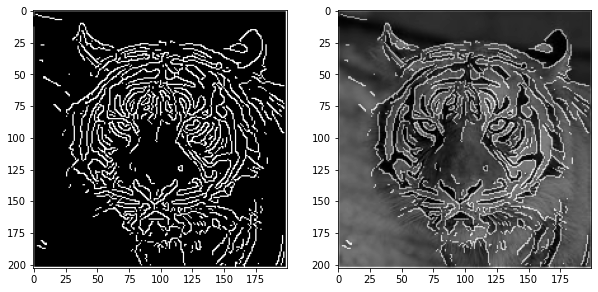

True

In [16]:
figure(figsize=(10, 10))

thinned_magnitude = non_maximum_suppression(magnitude, G_dir, 4)
plt.subplot(1,2,1)
plt.imshow(thinned_magnitude, cmap='gray')

overlay = 0.5*image + 0.5*(thinned_magnitude)
plt.subplot(1,2,2)
plt.imshow(overlay, cmap='gray')

plt.show()

cv2.imwrite('thinned_magnitude.jpg', thinned_magnitude)
cv2.imwrite('overlay.jpg', overlay)

#### All in one

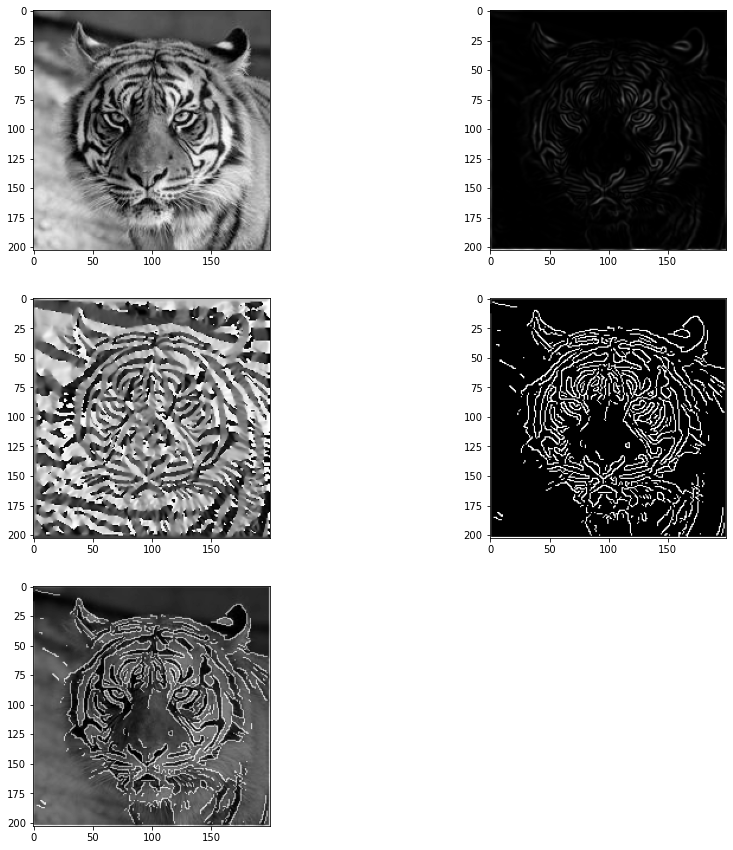

In [17]:
image_paths = ['tigerBW.jpg']

figure(figsize=(15, 15))

gaussian_window = 7

for i, image_path in enumerate(image_paths):
    image = cv2.imread(image_path, 0)
    plt.subplot(3, 2, 1)
    plt.imshow(image, cmap='gray')
    
    # Gaussian Filter
    gaussian = get_gaussian_filter(gaussian_window)
    gauss_vert = gaussian[:,None]
    gauss_hori = gaussian[None,:]
    
    # Gaussian Denoising
    blurred_image = cross_correlation(gauss_hori, image)
    blurred_image = cross_correlation(gauss_vert, blurred_image)
    
    # Derivative Filters
    fx = np.array([-1,0,1])
    fy = fx[:,None]
    
    # Derivative Images
    Gx = cross_correlation(fx, blurred_image)
    Gy = cross_correlation(fy, blurred_image)
    
    # Magnitude
    magnitude = (Gx**2 + Gy**2)
    magnitude = 255 * (magnitude / np.max(magnitude)) # normalize
    plt.subplot(3, 2, 2)
    plt.imshow(magnitude, cmap='gray')
    
    # Gradient Direction Image
    G_dir = np.zeros(shape=image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            G_dir[i,j] = np.arctan2(Gy[i,j], Gx[i,j])

    plt.subplot(3, 2, 3)
    plt.imshow(G_dir, cmap='gray')
    
    # Thin Edge Map
    thinned_magnitude = non_maximum_suppression(magnitude, G_dir, 4)
    plt.subplot(3,2,4)
    plt.imshow(thinned_magnitude, cmap='gray')
    
    overlay = 0.50*image + 0.50*(thinned_magnitude)
    plt.subplot(3,2,5)
    plt.imshow(overlay, cmap='gray')
    
    

#### Canny Comparison

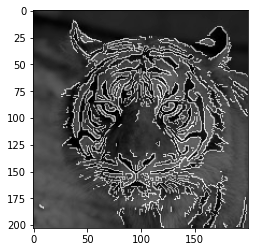

In [18]:
canny = cv2.Canny(image, 200, 255)
plt.imshow(canny+0.7*image, cmap='gray')

### 2) Cross-correlation and Template Matching

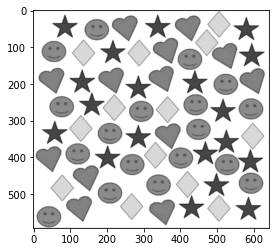

True

In [19]:
image = cv2.imread('count-objects-bw-crop.png', 0)

plt.imshow(image, cmap='gray')
plt.show()

cv2.imwrite('imt.png', image)

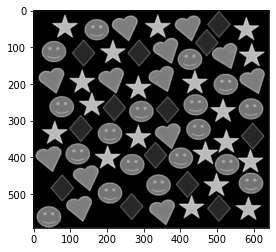

In [20]:
image = -1 * image + 255 # inverting
plt.imshow(image, cmap='gray')
plt.show()

#### Filter Choices (Star and Heart)

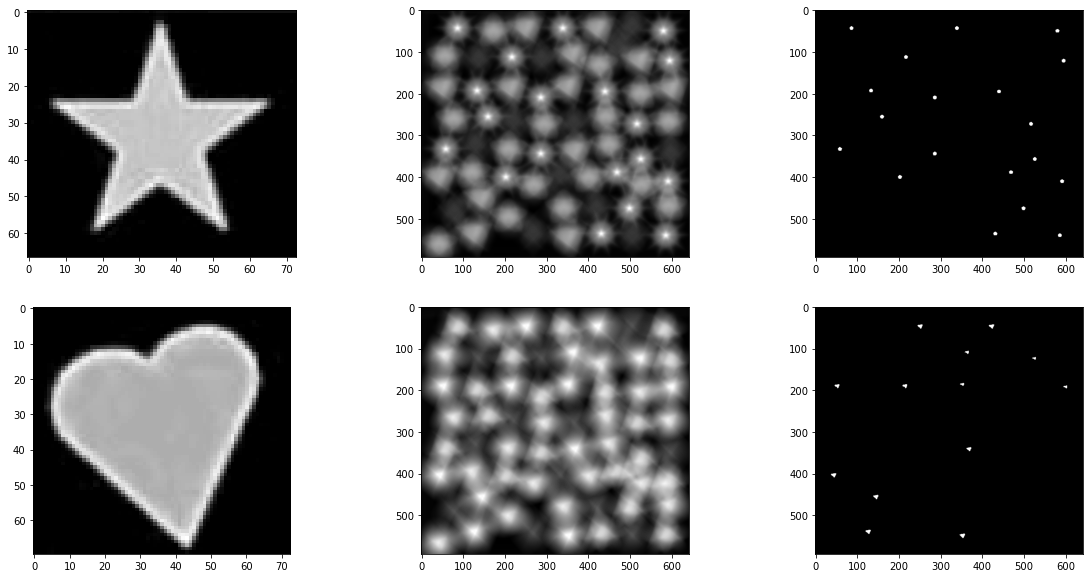

In [21]:
image_paths = ['star.png', 'heart.png']
image_thresholds = [220, 248]

figure = plt.figure(figsize=(20,10))

for i, image_path in enumerate(image_paths):
        
    f = cv2.imread(image_path, 0)
    f = -1 * f + 255
    plt.subplot(len(image_paths), 3, (i * 3) + 1)
    plt.imshow(f, cmap='gray')
    cv2.imwrite(str(i)+'1.png', f)
    
    res = cross_correlation(f, image)
    res = 255*(res / np.max(res))
    plt.subplot(len(image_paths), 3, (i * 3) + 2)
    plt.imshow(res, cmap='gray')
    cv2.imwrite(str(i)+'2.png', res)
    
    peaks_map = manual_threshold(res, image_thresholds[i])
    plt.subplot(len(image_paths), 3, (i * 3) + 3)
    plt.imshow(peaks_map, cmap='gray')
    cv2.imwrite(str(i)+'3.png', peaks_map)
    
plt.show()

